In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def collect_data_and_plot(df, test_mode, setting_name, underage_cost):
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'] + '/model.pt',
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/{row['# of stores']}/{row['Architecture Class']}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 24:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 32768
        batch_size = 32768
        num_batches = n_samples // batch_size
        num_steps = 500
        start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        n_stores = row['# of stores']
        avg_s_underage.append(relevant_data['s_underage_costs'].mean() / underage_cost)
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / underage_cost)
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / underage_cost)
        avg_cost.append(relevant_data['s_underage_costs'].sum() * n_stores + relevant_data['s_holding_costs'].sum() * n_stores + relevant_data['w_holding_costs'].sum())

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding 
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Calculate relative cost
    # Calculate cost as percentage of lowest cost
    # Calculate min cost for each number of stores
    df['cost'] = df.groupby('# of stores')['avg_cost'].transform(lambda x: x/x.min() * 100)

    plot_data = df.pivot(index="# of stores", columns='Architecture Class', 
                         values=['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Cost (% of minimum at each # of stores)', 'Average Store lost sales / (average unit underage cost)', 'Average Store Holding Cost / (average unit underage cost)', 'Average Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    x_values = df['# of stores'].unique()
    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                # Convert to numpy array before indexing
                plot_values = plot_data[y_value][arch].loc[x_values].to_numpy()
                ax.plot(x_values, plot_values, marker='o', label=f'{arch}',
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Number of stores')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


   # of stores                Architecture Class  Train Loss   Dev Loss  Test Loss  Test Gap %                                                                                                                                                                                                                                                                      path
0            3                               GNN    5.617466   5.602608   5.608438    0.000000                                /user/ml4723/Prj/NIC/ray_results/generic_architecture/GNN/3/run_2025-02-20_12-20-02/run_eb943_00005_5_config=one_warehouse_lost_demand,dev_batch_size=32768,dev_n_samples=32768,early_stop_check_epochs=10,gradient_cl_2025-02-20_12-20-02
0            3                decentralized_edge    5.663875   5.649258   5.656909    0.864249                 /user/ml4723/Prj/NIC/ray_results/generic_architecture/decentralized_edge/3/run_2025-03-08_20-43-54/run_f5740_00004_4_config=one_warehouse_lost_demand,dev_batch_size=32

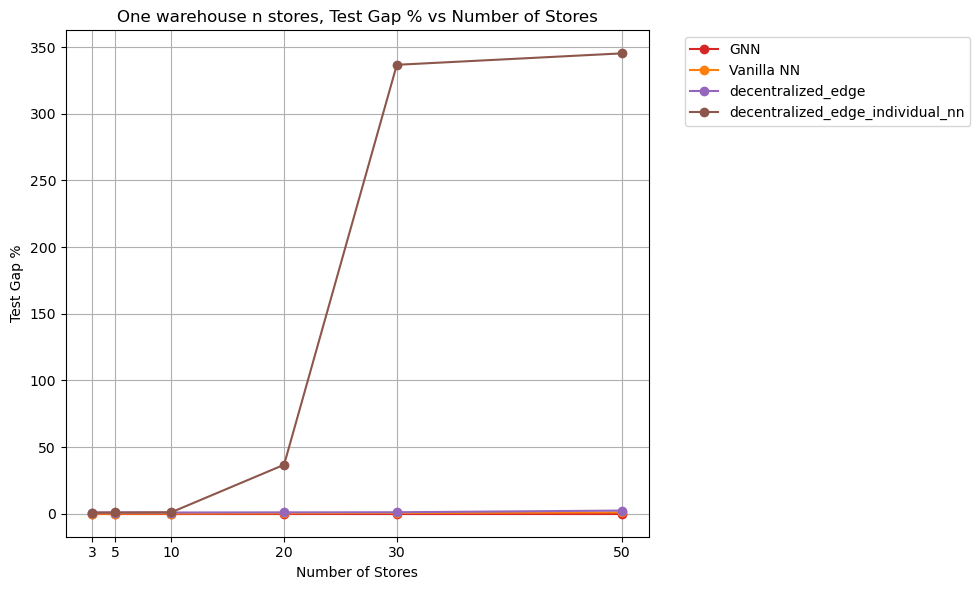

In [2]:
# Define color scheme for architecture types
color_scheme = {
    "GNN": "#d62728",  # Red
    "GNN_MP": "#2ca02c",  # Green
    "Vanilla NN": "#ff7f0e",  # Orange 
    "symmetry_aware": "#00ffff",  # Cyan
    "Benchmark": "#1f77b4",  # Blue
    "decentralized_edge": "#9467bd",  # Purple
    "decentralized_edge_individual_nn": "#8c564b"  # Brown
}

linestyle_scheme = {
    "GNN": "-",  # Solid
    "GNN_MP": "-",  # Solid
    "Vanilla NN": "-",  # Dashed
    "symmetry_aware": "-",  # Solid
    "Benchmark": "-",  # Dotted
    "decentralized_edge": "-",  # Solid
    "decentralized_edge_individual_nn": "-"  # Solid
}

testset_name = "generic_architecture"
n_stores_list = [3, 5, 10, 20, 30, 50]

gnn_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN/{n}'
    for n in n_stores_list
}

gnn_mp_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/{n}'
    for n in n_stores_list
}

symmetry_aware_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/symmetry_aware/{n}'
    for n in n_stores_list
}

vanilla_nn_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse/{n}'
    for n in n_stores_list
}

benchmark_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/CBS_one_warehouse/{n}'
    for n in n_stores_list
}

decentralized_edge_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/decentralized_edge/{n}'
    for n in n_stores_list
}

decentralized_edge_individual_nn_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/decentralized_edge_individual_nn/{n}'
    for n in n_stores_list
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# GNN
df_gnn = results_interpretor.make_table(gnn_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(2, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# GNN MP
df_gnn_mp = results_interpretor.make_table(gnn_mp_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp.insert(2, 'Architecture Class', "GNN_MP")
df_gnn_mp.insert(1, 'hyperparam_name', "GNN_MP")

# Symmetry Aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "symmetry_aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(2, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_one_warehouse")

# Benchmark (CBS)
df_benchmark = results_interpretor.make_table(benchmark_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_benchmark.insert(2, 'Architecture Class', "Benchmark")
df_benchmark.insert(1, 'hyperparam_name', "CBS_one_warehouse")

# Decentralized Edge
df_decentralized_edge = results_interpretor.make_table(decentralized_edge_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_decentralized_edge.insert(2, 'Architecture Class', "decentralized_edge")
df_decentralized_edge.insert(1, 'hyperparam_name', "decentralized_edge")

# Decentralized Edge Individual NN
df_decentralized_edge_individual = results_interpretor.make_table(decentralized_edge_individual_nn_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_decentralized_edge_individual.insert(2, 'Architecture Class', "decentralized_edge_individual_nn")
df_decentralized_edge_individual.insert(1, 'hyperparam_name', "decentralized_edge_individual_nn")

# Combine dataframes
df = pd.concat([
    df_gnn,
    # df_gnn_mp,
    # df_symmetry_aware,
    df_vanilla,
    # df_benchmark,
    df_decentralized_edge,
    df_decentralized_edge_individual
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col

df_to_print = df.copy()
df_to_analyze = df_to_print.copy()
columns_to_drop = ['train_n_samples', 'Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table
pivot_df = df.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()

# Plot lines for each architecture
for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column, 
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Number of Stores')
ax.set_ylabel('Test Gap %')
ax.set_title('One warehouse n stores, Test Gap % vs Number of Stores')
ax.grid(True)
ax.set_xticks(pivot_df.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [8]:
# Calculate average improvement of GNN_MP compared to other architectures
architectures = ['Vanilla NN', 'Benchmark', 'symmetry_aware']

improvements = {}
for arch in architectures:
    if arch in df_to_print['Architecture Class'].unique():
        # Group by number of stores and calculate relative improvement
        gnn_perf = df_to_print[df_to_print['Architecture Class'] == 'GNN'].set_index('# of stores')['Test Loss']
        other_perf = df_to_print[df_to_print['Architecture Class'] == arch].set_index('# of stores')['Test Loss']
        
        # Calculate improvement percentage
        common_stores = gnn_perf.index.intersection(other_perf.index)
        if len(common_stores) > 0:
            improvements[arch] = ((other_perf[common_stores] - gnn_perf[common_stores]) / other_perf[common_stores] * 100).mean()

print("\nAverage improvement of GNN compared to other architectures:")
for arch, imp in improvements.items():
    print(f"vs {arch}: {imp:.2f}%")



Average improvement of GNN compared to other architectures:
vs Vanilla NN: 0.35%
vs symmetry_aware: 0.26%


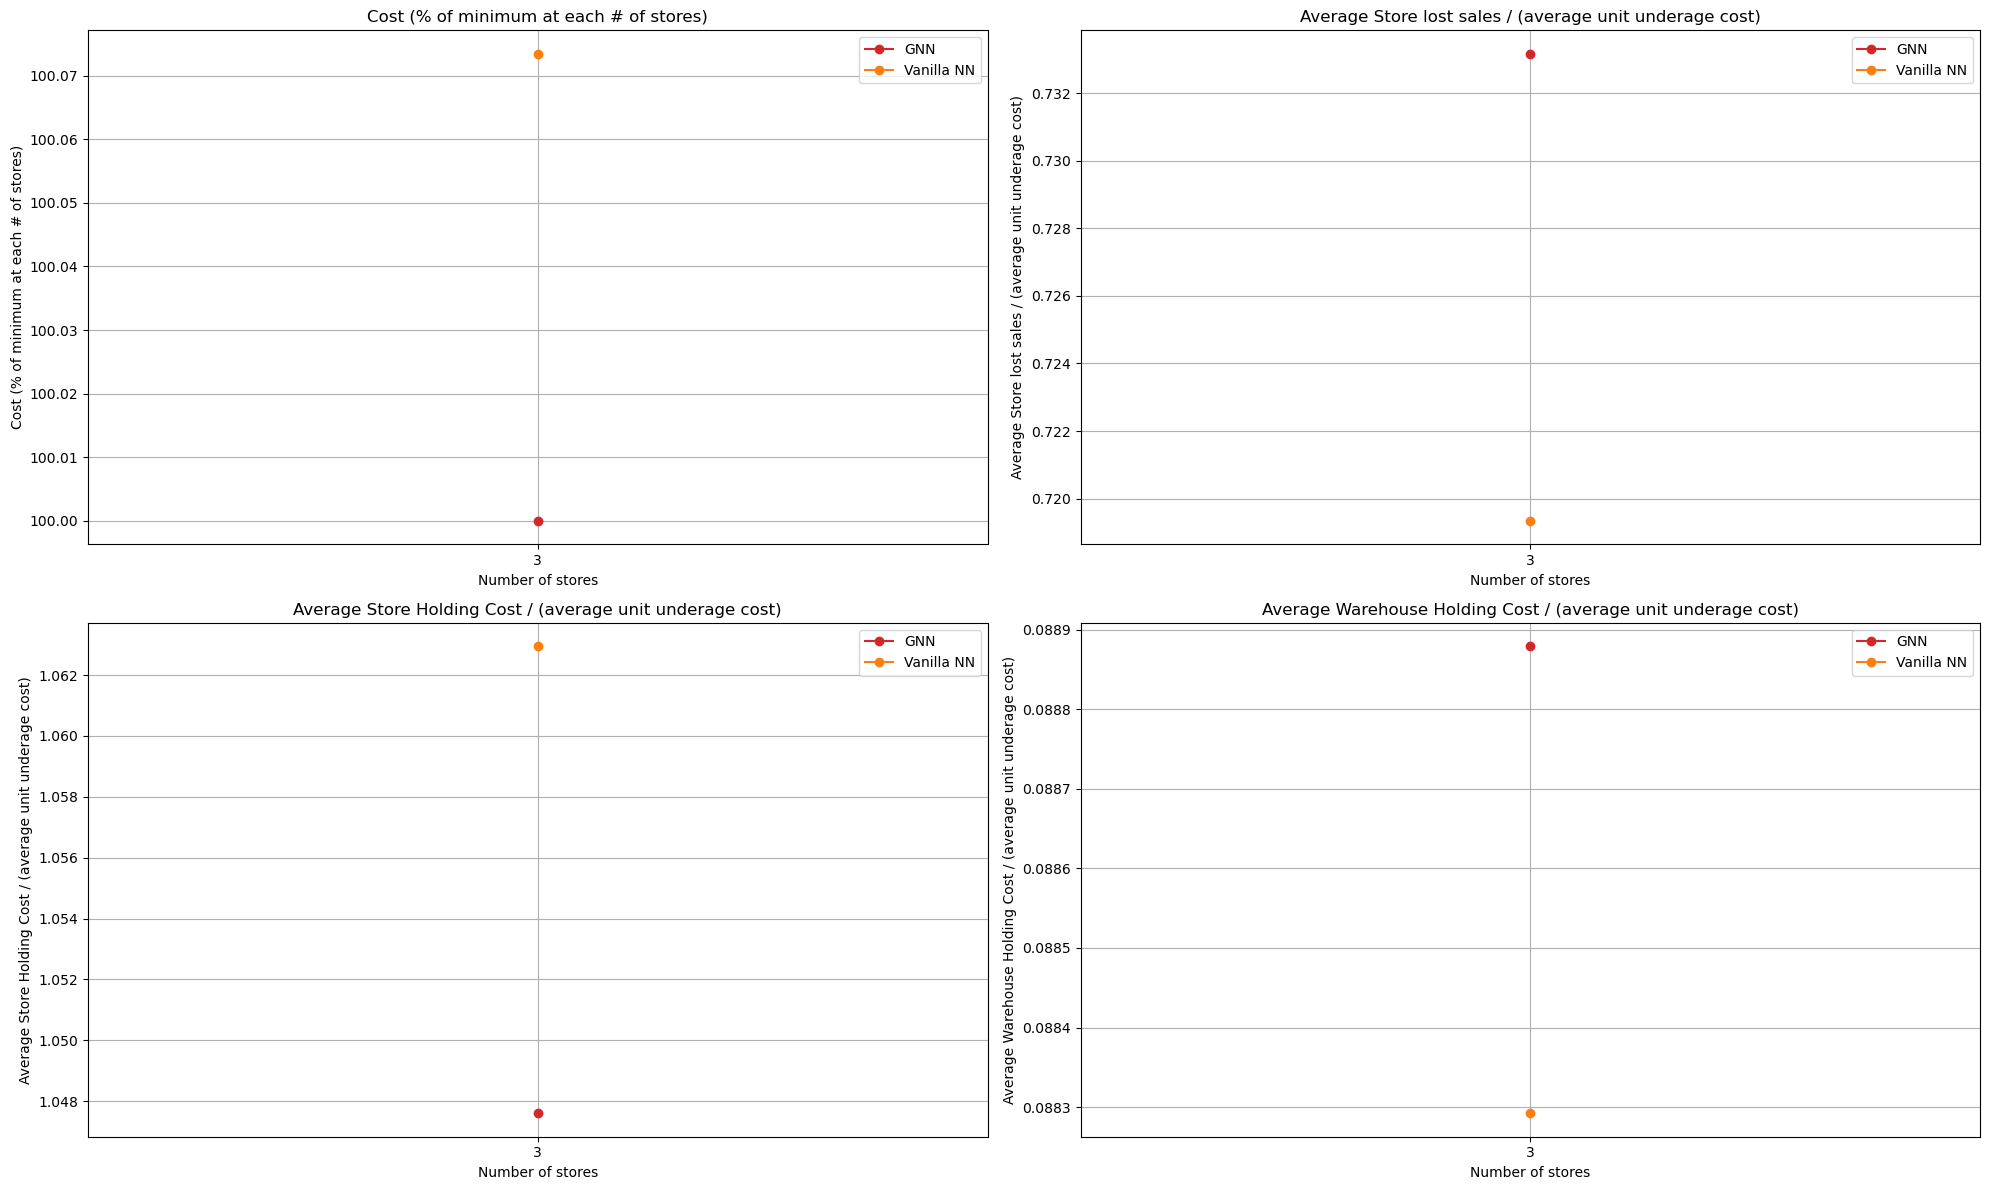

,# of stores,hyperparam_name,train_n_samples,Architecture Class,Learning Rate,Train Loss,Dev Loss,Test Loss,Test Gap %,path,# of runs,avg_s_underage,avg_s_holding,avg_w_holding,avg_cost,cost
0,3,GNN,32768,GNN,0.0001,5.617466,5.602608,5.608438,0.000000,/user/ml4723/Prj/NIC/ray_results/generic_archi...,9,0.733166,1.04760,0.088879,3.203439e+08,100.000000
0,3,vanilla_one_warehouse,32768,Vanilla NN,0.0001,5.612814,5.618465,5.610859,0.043168,/user/ml4723/Prj/NIC/ray_results/generic_archi...,27,0.719341,1.06295,0.088292,3.205791e+08,100.073447


In [12]:
df_to_analyze = df_to_analyze[df_to_analyze['# of stores'] == 3]
collect_data_and_plot(df_to_analyze, 'test', 'one_warehouse_lost_demand', 9.0)

   # of stores Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %
0            3             GNN_MP    5.492372  6.454728   5.816544    0.000000
0            3     symmetry_aware    5.737436  6.436946   5.879033    1.074339
0            3                GNN    6.017059  5.403199   5.837134    0.353997
1            5             GNN_MP    5.298563  4.947641   5.423098    0.556549
1            5     symmetry_aware    5.885405  4.954141   5.540000    2.724184
1            5                GNN    5.228527  5.085942   5.393083    0.000000
2           10     symmetry_aware    5.532275  5.542411   5.875375    0.530089
2           10                GNN    5.732549  5.704185   5.893030    0.832169
2           10             GNN_MP    5.365378  5.485015   5.844395    0.000000
3           20                GNN    6.030071  5.682686   6.094404    1.941033
3           20             GNN_MP    5.380623  5.842144   5.978362    0.000000
3           20     symmetry_aware    5.415864  5.818

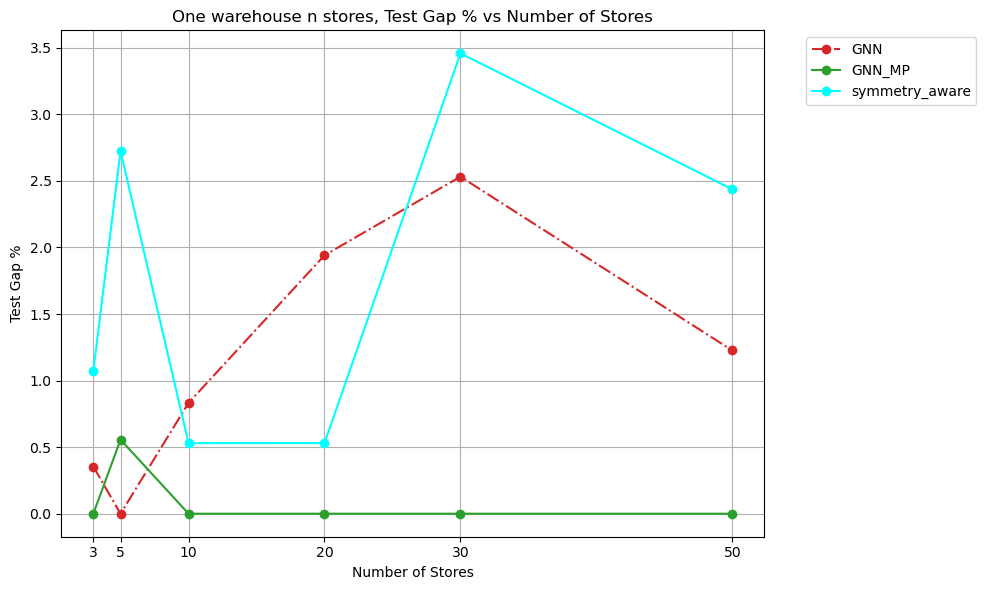

In [15]:
# Define color scheme for architecture types
color_scheme = {
    "GNN_MP": "#2ca02c",  # Green
    "Vanilla NN": "#ff7f0e",  # Orange 
    "symmetry_aware": "#00ffff",  # Cyan
    "Benchmark": "#1f77b4",  # Blue
    "GNN": "#d62728"  # Red
}

linestyle_scheme = {
    "GNN_MP": "-",  # Solid
    "Vanilla NN": "--",  # Dashed
    "symmetry_aware": "-",  # Solid
    "Benchmark": "-",  # Dotted
    "GNN": "-."  # Dash-dot
}

testset_name = "generic_architecture"
n_stores_list = [3, 5, 10, 20, 30, 50]

gnn_mp_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/{n}'
    for n in n_stores_list
}

gnn_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN/{n}'
    for n in n_stores_list
}

symmetry_aware_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/symmetry_aware/{n}'
    for n in n_stores_list
}

vanilla_nn_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse/{n}'
    for n in n_stores_list
}

benchmark_paths = {
    n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/CBS_one_warehouse/{n}'
    for n in n_stores_list
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# GNN MP
df_gnn_mp = results_interpretor.make_table(gnn_mp_paths,
    {"train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp.insert(2, 'Architecture Class', "GNN_MP")
df_gnn_mp.insert(1, 'hyperparam_name', "GNN_MP")

df_gnn = results_interpretor.make_table(gnn_paths,
    {"train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(2, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# Symmetry Aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {"train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "symmetry_aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {"train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(2, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_one_warehouse")

# Benchmark (CBS)
df_benchmark = results_interpretor.make_table(benchmark_paths,
    { "train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_benchmark.insert(2, 'Architecture Class', "Benchmark")
df_benchmark.insert(1, 'hyperparam_name', "CBS_one_warehouse")

# Combine dataframes
df = pd.concat([
    df_gnn_mp,
    df_gnn,
    df_symmetry_aware,
    # df_vanilla,
    # df_benchmark
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col

df_to_print = df.copy()
columns_to_drop = ['path', 'train_n_samples', 'Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table
pivot_df = df.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()

# Plot lines for each architecture
for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column, 
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Number of Stores')
ax.set_ylabel('Test Gap %')
ax.set_title('One warehouse n stores, Test Gap % vs Number of Stores')
ax.grid(True)
ax.set_xticks(pivot_df.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
# Calculate average improvement of GNN_MP compared to other architectures
architectures = ['Vanilla NN', 'Benchmark', 'symmetry_aware']

improvements = {}
for arch in architectures:
    if arch in df_to_print['Architecture Class'].unique():
        # Group by number of stores and calculate relative improvement
        gnn_perf = df_to_print[df_to_print['Architecture Class'] == 'GNN'].set_index('# of stores')['Test Loss']
        other_perf = df_to_print[df_to_print['Architecture Class'] == arch].set_index('# of stores')['Test Loss']
        
        # Calculate improvement percentage
        common_stores = gnn_perf.index.intersection(other_perf.index)
        if len(common_stores) > 0:
            improvements[arch] = ((other_perf[common_stores] - gnn_perf[common_stores]) / other_perf[common_stores] * 100).mean()

print("\nAverage improvement of GNN compared to other architectures:")
for arch, imp in improvements.items():
    print(f"vs {arch}: {imp:.2f}%")



Average improvement of GNN compared to other architectures:
vs Vanilla NN: 26.83%
vs symmetry_aware: 0.62%


In [45]:
# Calculate how much worse other architectures perform compared to GNN_MP
architectures = ['Vanilla NN', 'Benchmark', 'symmetry_aware', 'GNN']

performance_gaps = {}
for arch in architectures:
    if arch in df_to_print['Architecture Class'].unique():
        # Group by number of stores and calculate relative performance gap
        gnn_perf = df_to_print[df_to_print['Architecture Class'] == 'GNN_MP'].set_index('# of stores')['Test Loss']
        other_perf = df_to_print[df_to_print['Architecture Class'] == arch].set_index('# of stores')['Test Loss']
        
        # Calculate how much worse the other architecture performs
        common_stores = gnn_perf.index.intersection(other_perf.index)
        if len(common_stores) > 0:
            performance_gaps[arch] = ((other_perf[common_stores] - gnn_perf[common_stores]) / gnn_perf[common_stores] * 100).mean()

print("\nHow much worse other architectures perform compared to GNN_MP:")
for arch, gap in performance_gaps.items():
    print(f"{arch} is {gap:.2f}% worse")



How much worse other architectures perform compared to GNN_MP:
Benchmark is 17.29% worse
symmetry_aware is 1.70% worse
GNN is 1.06% worse


In [30]:
# Define color scheme for architecture types
color_scheme = {
    "GNN_MP": "#2ca02c",  # Green
    "GNN_MP_individual_weights": "#9467bd",  # Purple
    "GNN_MP_shared_weights": "#ff7f0e",  # Orange
    "Vanilla NN": "#1f77b4",  # Blue
    "symmetry_aware": "#00ffff",  # Cyan
    "Benchmark": "#d62728"  # Red
}

linestyle_scheme = {
    "GNN_MP": "-",  # Solid
    "GNN_MP_individual_weights": "-",  # Solid 
    "GNN_MP_shared_weights": "-",  # Solid
    "Vanilla NN": "-",  # Solid
    "symmetry_aware": "-",  # Solid
    "Benchmark": "-"  # Solid
}

testset_name = "generic_architecture"
n_stores = 50

gnn_mp_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/{n_stores}'
}

gnn_mp_individual_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_individual_weights/{n_stores}'
}

gnn_mp_shared_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_shared_weights/{n_stores}'
}

symmetry_aware_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/symmetry_aware/{n_stores}'
}

vanilla_nn_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse/{n_stores}'
}

benchmark_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/CBS_one_warehouse/{n_stores}'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# GNN MP
df_gnn_mp = results_interpretor.make_table(gnn_mp_paths,
    {'samples': [1,2,3], "train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp.insert(2, 'Architecture Class', "GNN_MP")
df_gnn_mp.insert(1, 'hyperparam_name', "GNN_MP")

# GNN MP Individual Weights
df_gnn_mp_individual = results_interpretor.make_table(gnn_mp_individual_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_individual.insert(2, 'Architecture Class', "GNN_MP_individual_weights")
df_gnn_mp_individual.insert(1, 'hyperparam_name', "GNN_MP_individual_weights")

# GNN MP Shared Weights
df_gnn_mp_shared = results_interpretor.make_table(gnn_mp_shared_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_shared.insert(2, 'Architecture Class', "GNN_MP_shared_weights")
df_gnn_mp_shared.insert(1, 'hyperparam_name', "GNN_MP_shared_weights")

# Symmetry Aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "symmetry_aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(2, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_one_warehouse")

# Benchmark (CBS)
df_benchmark = results_interpretor.make_table(benchmark_paths,
    {"train_n_samples": [32768]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_benchmark.insert(2, 'Architecture Class', "Benchmark")
df_benchmark.insert(1, 'hyperparam_name', "CBS_one_warehouse")

# Combine dataframes
df = pd.concat([
    df_gnn_mp,
    df_gnn_mp_individual,
    df_gnn_mp_shared,
    df_symmetry_aware,
    df_vanilla,
    df_benchmark
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col

df_to_print = df.copy()
# Calculate mean and variance of test loss grouped by # of stores and architecture class
variance_df = df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].agg(['mean', 'std']).reset_index()
variance_df.columns = ['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Std']

# Round variance to 6 decimal places
variance_df['Test Loss Std'] = variance_df['Test Loss Std'].round(6)
variance_df['Mean Test Loss'] = variance_df['Mean Test Loss'].round(6)

# Merge mean and variance back into main dataframe
df_to_print = df_to_print.merge(
    variance_df[['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Std']], 
    on=['# of stores', 'Architecture Class'],
    how='left'
)

# Keep only the row with minimum test loss for each combination of '# of stores' and 'Architecture Class'
df_to_print = df_to_print.loc[df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].idxmin()]

columns_to_drop = ['path', 'train_n_samples', 'samples', 'Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

   # of stores         Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %  Mean Test Loss  Test Loss Std
7           50                  Benchmark    6.170629  6.156301   6.206020   16.240542        6.206020            NaN
1           50                     GNN_MP    5.343781  5.341660   5.338946    0.000000        5.339304        0.00042
3           50  GNN_MP_individual_weights    5.393903  5.395151   5.392611    1.005151        5.392611            NaN
4           50      GNN_MP_shared_weights    5.395748  5.395651   5.392876    1.010119        5.392876            NaN
6           50                 Vanilla NN    5.388254  5.395189   5.391469    0.983764        5.391469            NaN
5           50             symmetry_aware    5.372848  5.371639   5.368375    0.551205        5.368375            NaN


In [31]:
# Calculate improvement percentages
improvements = []
for n_stores in df_to_print['# of stores'].unique():
    store_data = df_to_print[df_to_print['# of stores'] == n_stores]
    
    gnn_mp_loss = store_data[store_data['Architecture Class'] == 'GNN_MP']['Test Loss'].values[0]
    individual_loss = store_data[store_data['Architecture Class'] == 'GNN_MP_individual_weights']['Test Loss'].values[0]
    shared_loss = store_data[store_data['Architecture Class'] == 'GNN_MP_shared_weights']['Test Loss'].values[0]
    
    individual_improvement = ((individual_loss - gnn_mp_loss) / individual_loss) * 100
    shared_improvement = ((shared_loss - gnn_mp_loss) / shared_loss) * 100
    
    improvements.append({
        '# of stores': n_stores,
        'Improvement over Individual (%)': individual_improvement,
        'Improvement over Shared (%)': shared_improvement
    })

improvement_df = pd.DataFrame(improvements)
print("\nGNN_MP Improvements:")
print(improvement_df.to_string(float_format=lambda x: '{:.2f}'.format(x)))



GNN_MP Improvements:
   # of stores  Improvement over Individual (%)  Improvement over Shared (%)
0           50                             1.00                         1.00


In [32]:
# Define color scheme for architecture types
color_scheme = {
    "GNN_MP": "#2ca02c",  # Green
    "GNN_MP_individual_weights": "#9467bd",  # Purple
    "GNN_MP_shared_weights": "#ff7f0e",  # Orange
    "Vanilla NN": "#1f77b4",  # Blue
    "symmetry_aware": "#00ffff"  # Cyan
}

linestyle_scheme = {
    "GNN_MP": "-",  # Solid
    "GNN_MP_individual_weights": "-",  # Solid 
    "GNN_MP_shared_weights": "-",  # Solid
    "Vanilla NN": "-",  # Solid
    "symmetry_aware": "-"  # Solid
}

testset_name = "generic_architecture"
n_stores = 50

gnn_mp_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/{n_stores}'
}

gnn_mp_individual_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_individual_weights/{n_stores}'
}

gnn_mp_shared_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_shared_weights/{n_stores}'
}

symmetry_aware_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/symmetry_aware/{n_stores}'
}

vanilla_nn_paths = {
    n_stores: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_warehouse/{n_stores}'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# GNN MP
df_gnn_mp = results_interpretor.make_table(gnn_mp_paths,
    {"train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp.insert(2, 'Architecture Class', "GNN_MP")
df_gnn_mp.insert(1, 'hyperparam_name', "GNN_MP")

# GNN MP Individual Weights
df_gnn_mp_individual = results_interpretor.make_table(gnn_mp_individual_paths,
    {"train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_individual.insert(2, 'Architecture Class', "GNN_MP_individual_weights")
df_gnn_mp_individual.insert(1, 'hyperparam_name', "GNN_MP_individual_weights")

# GNN MP Shared Weights
df_gnn_mp_shared = results_interpretor.make_table(gnn_mp_shared_paths,
    {"train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp_shared.insert(2, 'Architecture Class', "GNN_MP_shared_weights")
df_gnn_mp_shared.insert(1, 'hyperparam_name', "GNN_MP_shared_weights")

# Symmetry Aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {"train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "symmetry_aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {"train_n_samples": [16]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(2, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_one_warehouse")

# Combine dataframes
df = pd.concat([
    df_gnn_mp,
    df_gnn_mp_individual,
    df_gnn_mp_shared,
    df_symmetry_aware,
    df_vanilla
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col

df_to_print = df.copy()
# Calculate mean and variance of test loss grouped by # of stores and architecture class
variance_df = df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].agg(['mean', 'std']).reset_index()
variance_df.columns = ['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Std']

# Round variance to 6 decimal places
variance_df['Test Loss Std'] = variance_df['Test Loss Std'].round(6)
variance_df['Mean Test Loss'] = variance_df['Mean Test Loss'].round(6)

# Merge mean and variance back into main dataframe
df_to_print = df_to_print.merge(
    variance_df[['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Std']], 
    on=['# of stores', 'Architecture Class'],
    how='left'
)

# Keep only the row with minimum test loss for each combination of '# of stores' and 'Architecture Class'
df_to_print = df_to_print.loc[df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].idxmin()]

columns_to_drop = ['path', 'train_n_samples', 'samples', 'Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

   # of stores         Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %  Mean Test Loss  Test Loss Std
0           50                     GNN_MP    5.414314  5.077227   5.516900    0.000000        5.516900            NaN
1           50  GNN_MP_individual_weights    5.554988  5.313625  11.314541  105.088753       11.314541            NaN
2           50      GNN_MP_shared_weights    5.663556  5.197677   6.914699   25.336679        6.914699            NaN
4           50                 Vanilla NN    5.844695  6.416362   9.932380   80.035522        9.932380            NaN
3           50             symmetry_aware    5.639233  5.039232   5.651337    2.436823        5.651337            NaN


In [33]:
# Calculate improvement percentages
improvements = []
for n_stores in df_to_print['# of stores'].unique():
    store_data = df_to_print[df_to_print['# of stores'] == n_stores]
    
    gnn_mp_loss = store_data[store_data['Architecture Class'] == 'GNN_MP']['Test Loss'].values[0]
    individual_loss = store_data[store_data['Architecture Class'] == 'GNN_MP_individual_weights']['Test Loss'].values[0]
    shared_loss = store_data[store_data['Architecture Class'] == 'GNN_MP_shared_weights']['Test Loss'].values[0]
    
    individual_improvement = ((individual_loss - gnn_mp_loss) / individual_loss) * 100
    shared_improvement = ((shared_loss - gnn_mp_loss) / shared_loss) * 100
    
    improvements.append({
        '# of stores': n_stores,
        'Improvement over Individual (%)': individual_improvement,
        'Improvement over Shared (%)': shared_improvement
    })

improvement_df = pd.DataFrame(improvements)
print("\nGNN_MP Improvements:")
print(improvement_df.to_string(float_format=lambda x: '{:.2f}'.format(x)))



GNN_MP Improvements:
   # of stores  Improvement over Individual (%)  Improvement over Shared (%)
0           50                            51.24                        20.21


    # of stores Architecture Class  Train Loss   Dev Loss  Test Loss  warehouse_holding_cost  Test Gap % omit_context_from_store_input  Mean Test Loss  Test Loss Std
0             3             GNN_MP    8.168971   8.153680   8.155499                     NaN    0.000000                           NaN        8.155681       0.000204
6             3     symmetry_aware    8.156511   8.164629   8.159318                     0.7    0.046829                         False        8.159994       0.000618
3             3            vanilla    8.160265   8.166241   8.161128                     0.7    0.069022                           NaN        8.166442       0.006011
20           10             GNN_MP   24.447174  24.628096  24.493309                     NaN    0.000000                           NaN       24.504348       0.013416
15           10     symmetry_aware   24.483603  24.525838  24.518554                     0.7    0.103070                         False       24.522358       0.003899
13  

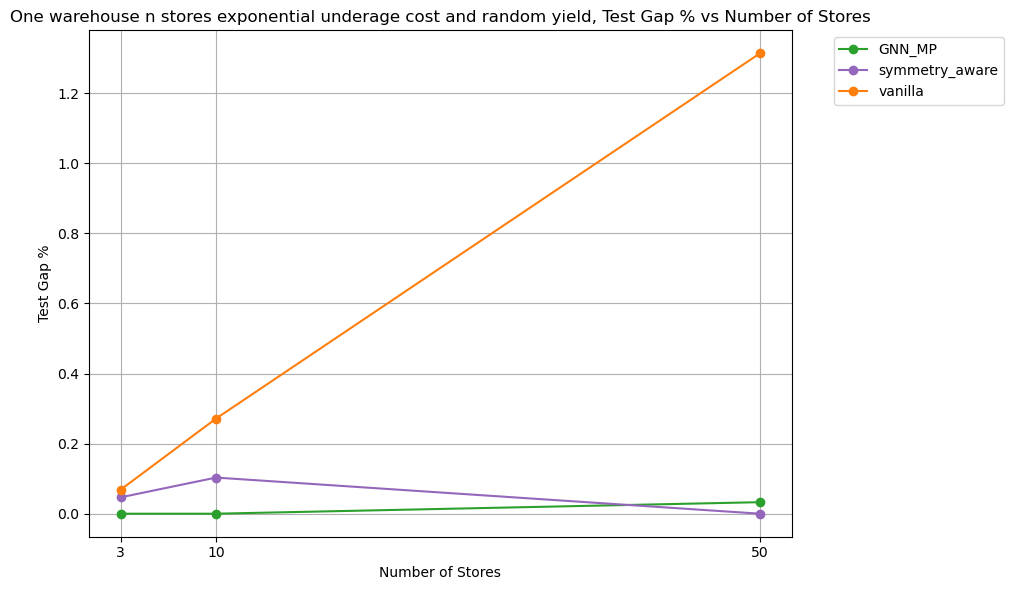

In [2]:
# Define color scheme for architecture types
color_scheme = {
    "GNN_MP": "#2ca02c",  # Orange
    "symmetry_aware": "#9467bd",  # Purple
    "vanilla": "#ff7f0e"  # Blue
}

linestyle_scheme = {
    "GNN_MP": "-",  # Solid
    "symmetry_aware": "-",  # Solid
    "vanilla": "-"  # Solid
}

testset_name = "generic_architecture_hard"
gnn_mp_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP/50'
}

symmetry_aware_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/warehouse_exp_underage_cost_random_yield/symmetry_aware/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/warehouse_exp_underage_cost_random_yield/symmetry_aware/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/warehouse_exp_underage_cost_random_yield/symmetry_aware/50'
}

vanilla_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/warehouse_exp_underage_cost_random_yield/vanilla/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/warehouse_exp_underage_cost_random_yield/vanilla/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/warehouse_exp_underage_cost_random_yield/vanilla/50'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# GNN MP
df_gnn_mp = results_interpretor.make_table(gnn_mp_paths,
    {'samples': [1,2,3]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn_mp.insert(2, 'Architecture Class', "GNN_MP")
df_gnn_mp.insert(1, 'hyperparam_name', "GNN_MP")

df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {'samples': [1,2,3,4], 'warehouse_holding_cost':[0.7], 'store_orders_for_warehouse': False, 'omit_context_from_store_input': False},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "symmetry_aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# Vanilla
df_vanilla = results_interpretor.make_table(vanilla_paths,
    {'samples': [1,2,3,4], 'warehouse_holding_cost':[0.7]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(2, 'Architecture Class', "vanilla")
df_vanilla.insert(1, 'hyperparam_name', "vanilla")

# Combine dataframes
df = pd.concat([
    df_gnn_mp,
    df_symmetry_aware,
    df_vanilla
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col

df_to_print = df.copy()
# Calculate mean and std of test loss grouped by # of stores and architecture class
variance_df = df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].agg(['mean', 'std']).reset_index()
variance_df.columns = ['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Std']

# Round std to 6 decimal places
variance_df['Test Loss Std'] = variance_df['Test Loss Std'].round(6)
variance_df['Mean Test Loss'] = variance_df['Mean Test Loss'].round(6)

# Merge mean and std back into main dataframe
df_to_print = df_to_print.merge(
    variance_df[['# of stores', 'Architecture Class', 'Mean Test Loss', 'Test Loss Std']], 
    on=['# of stores', 'Architecture Class'],
    how='left'
)

# Keep only the row with minimum test loss for each combination of '# of stores' and 'Architecture Class'
df_to_print = df_to_print.loc[df_to_print.groupby(['# of stores', 'Architecture Class'])['Test Loss'].idxmin()]

columns_to_drop = ['path', 'samples', 'Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table
pivot_df = df.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].min().unstack()

# Plot lines for each architecture
for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column, 
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Number of Stores')
ax.set_ylabel('Test Gap %')
ax.set_title('One warehouse n stores exponential underage cost and random yield, Test Gap % vs Number of Stores')
ax.grid(True)
ax.set_xticks(pivot_df.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()